# Makemore

Noted, Coded, and Created by Han Summer 2024. Part of The 20th Summer Project

------------
### Makemore

Making more things from the data given to the model.

Under the hood, **makemore is character level language model**, it means treating every single line example of data from the training set as a sequence of individual characters.

Character level language model, simpelnya cuman prediksi huruf yang selanjutnya berdasarkan sequence huruf yang udah ada (before it)

# Makemore + Attention is All You Need

Full Indonesian Language

[Attention is All You Need](https://arxiv.org/abs/1706.03762)

**The Transformers**

**GPT -> Generative Pre-trained Transformers**

Jadi, si GPT nge-model urutan kata/karakter/huruf atau yang lebih tepatnya token, terus dia bisa ngurutin bagaimana urutan tiap token/kata di dalam sebuah rangkaian (kayak kalimat yang buat)

Jadi, di ChatGPT, si model kerjaannya cuman ngelanjutin sequence dari prompt yang dikasih sebagai outputnya

Nah ChatGPT ini bisa kerja berdasarkan paper Transformers (Attention is All You Need [2017]) yang bisa dibilang revolutioner

Awalnya si transformers ini dibuat untuk kerjaan translate kayak google translate, tapi ya ga sengaja tiba tiba bagus

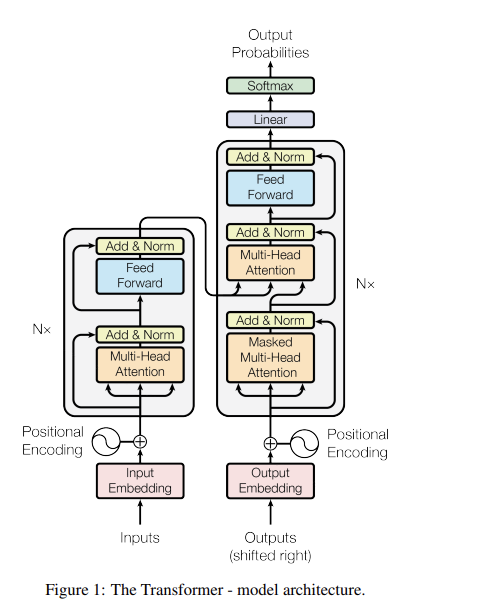

Arsitektur yang diatas ini bisa di ubah tipis tipis bisa punya banyak implementasi/fungsi

Di sini kita coba implementasi GPT ke makemore. Gamungkin dong reproduce ChatGPT modelnya sangat cape dibuat bagi seorang diri saya

## Characters level Language model - Makemore with Transformers

NANO-GPT

### Dataset

tiny shake speare (1mb)

Dataset ini dipake untuk training supaya model gimana urutan tiap karakter berdasarkan konteks dari sebelumnya

In [3]:
with open('tinyshakespeare.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [5]:
#Length of char in dataset
len(text)

1115394

In [7]:
#First 1000 char
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



Vocabulary

In [17]:
#Ambil semua karakter unik dalam dataset
chars=sorted(list(set(text)))
vocab_size=len(chars)
print("".join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


### Tokenizer

Ngubah token jadi sebuah integer, karena mesin kan ga ngerti huruf jadi kita coba convert supaya mesin ngerti

Di sini kita coba karakter/huruf sebagai token

In [18]:
#Buat tabel untuk mapping karakter ke integer dan sebaliknya
stoi={ch:i for i,ch in enumerate(chars)}
itos={i:ch for i,ch in enumerate(chars)}
#Encode (string->char to int)
encode=lambda s: [stoi[ch] for ch in s]
#Decode (int->char to string)
decode=lambda l: "".join([itos[i] for i in l])

In [12]:
print(encode("hello"))

[46, 43, 50, 50, 53]


In [15]:
print(decode([46, 43, 50, 50, 53]))

hello


In [16]:
print(decode(encode('hello')))

hello


Itu adalah contoh tokenizer sederhana. Ada implementasi lain yang lebih kompleks kayak google-sentencepiece dan OpenAI-TikToken (sub-word tokenizer), vocab lengthnya pasti lebih gede

**Encoding all dataset**

In [19]:
import torch
data=torch.tensor(encode(text),dtype=torch.long)
data.shape, data.dtype

(torch.Size([1115394]), torch.int64)

In [22]:
#First 1000 char encoded, semua huruf/kata di dataset diubah menjadi kumpulan angka int di dataset
print(data[:1000])

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
        47, 59, 57,  1, 47, 57,  1, 41, 

### Train-Val Split

In [24]:
#Misahin data menjadi train set dan validation set, supaya model bisa belajar dan diuji, kemudian kita bisa cek ga ada overfitting, ga nginget dataset doang
n= int(0.9*len(data))
train_data=data[:n]
val_data=data[n:]

### Feeding the data to transformer

Sekarang saatnya kita persiapkan data buat training ke arsitektur transformersnya. Tapi ga langsung 1 data gede dicemplungin buat training, terlalu berat dan kemahalan. Jadi, kita bakal ambil beberapa bagian (chunks) random di datasetnya

In [26]:
#Chunks/Context length, panjang dari input sequence
block_size=8
#Contoh simple 1 chunk = 8 char + 1 label
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

berarti disini inputnya bakal [18, 47, 56, 57, 58,  1, 15, 47] dan desired output/labelnya [58]